### Memory in RAG

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain.chat_models import init_chat_model

llm=init_chat_model("openai:gpt-5")

llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000253476FE270>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000253476FECF0>, root_client=<openai.OpenAI object at 0x0000025347423380>, root_async_client=<openai.AsyncOpenAI object at 0x00000253476FEA50>, model_name='gpt-5', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [4]:
from langchain_openai import OpenAIEmbeddings
embeddings=OpenAIEmbeddings()
embeddings

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x0000025347C70050>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x0000025347C702F0>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [5]:
## Document Ingestion And Processing
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [7]:
## chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [8]:
## Vector Store

from langchain_community.vectorstores import FAISS
vector_store=FAISS.from_documents(
    documents=all_splits,
    embedding=embeddings
)
print(f"Vector store created with {vector_store.index.ntotal} vectors")

Vector store created with 63 vectors


In [9]:
from langchain.agents import tool

In [10]:
@tool()
def retrieve(query:str):
    """Retrieve the information related to the query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [11]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [12]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [13]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'retrieve': StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x000002536A408B80>)}, tool_to_state_args={'retrieve': {}}, tool_to_store_arg={'retrieve': None}, handle_tool_errors=True, messages_key='messages')

In [14]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

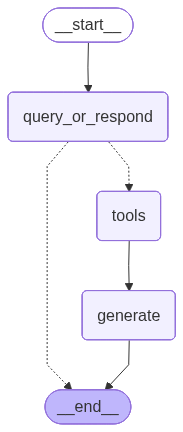

In [15]:
# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

In [16]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [17]:
input_message="Hello"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()
    

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [18]:
vector_store.similarity_search("What is TAsk Decomposition")

[Document(id='dc1ffabf-4ca7-4044-91ae-07fe1211d63b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f

In [20]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking a complex goal into smaller, well-defined subtasks that are easier to plan, execute, and verify.

Why it helps
- Clarifies scope and “definition of done”
- Improves estimating, prioritization, and parallel work
- Reduces risk and makes progress measurable

How to do it (quickly)
- Define the desired outcome
- List the steps needed and their dependencies
- Make each subtask small, testable, and ownable

Example
- Goal: “Launch a webinar” → choose topic, secure speaker, build landing page, create slides, set reminders, rehearse, run event, send recording.

If you share your domain (software, research, ops, personal), I can outline a tailored decomposition.


In [21]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_pjsiwiuheetuC4Y2eL6xc2fM)
 Call ID: call_pjsiwiuheetuC4Y2eL6xc2fM
  Args:
    query: Common methods/approaches for task decomposition across fields (project management, software engineering, HCI, AI). Include: Work Breakdown Structure (WBS), Functional Decomposition, Hierarchical Task Analysis (HTA), Goal-Directed Task Analysis (GDTA), Top-Down Design/Divide and Conquer, User Stories/Epics, PERT/CPM, Design Structure Matrix (DSM), MapReduce/pipelines, OKR → initiatives, AI prompting (chain-of-thought, least-to-most, tree-of-thought, ReAct), Hierarchical Task Networks (HTN), Options in hierarchical RL. Provide brief descriptions and when to use.
================================= Tool Message =================================
Name: retrieve

('Source: {\

In [22]:
### Conversation History
chat_history=graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?
================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the practice of breaking a complex goal or problem into smaller, manageable sub-tasks that are easier to plan, execute, and evaluate.

Why it’s useful
- Clarifies scope and “what done looks like”
- Improves estimates and prioritization
- Enables parallel work and reuse of components
- Reduces risk by isolating tricky parts
- Makes progress trackable and testable

Where it’s used
- Project/product management: Work Breakdown Structures (WBS), epics → stories → tasks
- Software/algorithms: divide-and-conquer, modular design, unit tests
- AI/planning: hierarchical planning (HTN), 

### ReAct Agent Architecture-Persistant Memory

In [23]:
retrieve

StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x000002536A408B80>)

In [24]:
from langgraph.prebuilt import create_react_agent
memory = MemorySaver()
agent_executor=create_react_agent(llm,[retrieve],checkpointer=memory)

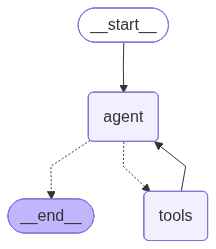

In [25]:
agent_executor

In [26]:
config = {"configurable": {"thread_id": "def234"}}

In [27]:
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

In [28]:
for event in agent_executor.stream({"messages": [{"role": "user", "content": input_message}]},
                                   stream_mode="values",
                                   config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_JcC6c1wkp5X0veVSxdK8burM)
 Call ID: call_JcC6c1wkp5X0veVSxdK8burM
  Args:
    query: "standard method for task decomposition" AI planning
  retrieve (call_eafeKnNBHfBTwyCGK61KGp0n)
 Call ID: call_eafeKnNBHfBTwyCGK61KGp0n
  Args:
    query: Task decomposition standard method HTN planning
  retrieve (call_WgtGNuecLo4tZSAZDZ8VOJWk)
 Call ID: call_WgtGNuecLo4tZSAZDZ8VOJWk
  Args:
    query: Common extensions of HTN planning task decomposition
  retrieve (call_LpTJ6NLP0bsysGVmbmISSkI9)
 Call ID: call_LpTJ6NLP0bsysGVmbmISSkI9
  Args:
    query: What is task decomposition standard method software engineering "task decomposition"
  retrieve (call_s069W43a0O3Gen4UsLsmtmvg)
 Call ID: call_